In [1]:
from dask_yarn import YarnCluster
from dask.distributed import Client
import dask

/home/hadoop/miniconda/lib/python3.7/site-packages/dask_yarn/core.py:16: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import (
/home/hadoop/miniconda/lib/python3.7/site-packages/dask_yarn/core.py:16: FutureWarning: parse_timedelta is deprecated and will be removed in a future release. Please use dask.utils.parse_timedelta instead.
  from distributed.utils import (


In [2]:
# Create a cluster where each worker has 4 vCPU core and 8 GiB of memory:
cluster = YarnCluster(environment="/home/hadoop/environment.tar.gz",
                      worker_vcores = 4,
                      worker_memory = "8GiB"
                      )

# Scale cluster out to 2 such workers:
cluster.scale(2)

# Connect to the cluster (before proceeding, you should wait for workers to be registered by the dask scheduler, as below):
client = Client(cluster)

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tcp://172.31.25.252:40861
distributed.scheduler - INFO -   dashboard at:                    :35941
distributed.scheduler - INFO - Receive client connection: Client-30fe7718-5a22-11ec-8cbe-0ad7bf2eb063
distributed.core - INFO - Starting established connection


In [3]:
client

Connection method: Cluster object,Cluster type: dask_yarn.YarnCluster
Dashboard: /proxy/35941/status,


### Data loading using dask

In [4]:
import dask.dataframe as dd
df = dd.read_csv("s3://yijingzhang-bucket/train.csv")

In [5]:
df.columns

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation'],
      dtype='object')

In [6]:
import pandas as pd
pd.options.display.max_rows =99
print(df.dtypes)

row_id                              int64
timestamp                           int64
user_id                             int64
content_id                          int64
content_type_id                     int64
task_container_id                   int64
user_answer                         int64
answered_correctly                  int64
prior_question_elapsed_time       float64
prior_question_had_explanation     object
dtype: object


In [7]:
df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 10 entries, row_id to prior_question_had_explanation
dtypes: object(1), float64(1), int64(8)

In [8]:
df.head()

distributed.scheduler - INFO - Register worker <WorkerState 'tcp://172.31.26.25:35837', name: dask.worker_0, status: undefined, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://172.31.26.25:35837
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://172.31.26.183:38973', name: dask.worker_1, status: undefined, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://172.31.26.183:38973
distributed.core - INFO - Starting established connection


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [9]:
# Calling dask.compute() with multiple objects allows for shared computation steps, e.g., file loading, and reduces overall runtime
num_content_ids, num_task_ids, num_content_types = dask.compute(df['content_id'].nunique(),\
                                                               df['task_container_id'].nunique(),\
                                                               df['content_type_id'].nunique())
print("Unique content IDs: {}".format(num_content_ids))
print("Unique task container IDs: {}".format(num_task_ids))
print("Number of content types: {}".format(num_content_types))

Unique content IDs: 13782
Unique task container IDs: 10000
Number of content types: 2


### How many users in total?


In [10]:
print("Total number of users: {}".format(df['user_id'].nunique().compute()))

Total number of users: 393656


### The proportion of correct answers

In [11]:
print("Correct rate of all answers: {:.2f}%".format(df[df['content_type_id']==0]['answered_correctly'].mean().compute() * 100))

Correct rate of all answers: 65.72%


### Explore the questions

In [12]:
# Aggregating at the content (question) level
content_df = (df.query("content_type_id==0")
              .groupby('content_id')
              .agg({'user_id': 'count',
                    'answered_correctly': 'mean'})
              .compute())

In [13]:
content_df

,user_id,answered_correctly
content_id,,
0,6903,0.907721
1,7398,0.890646
2,44905,0.554281
3,22973,0.779437
4,31736,0.613215
...,...,...
5823,1,1.000000
10005,1,1.000000
10006,1,1.000000


In [14]:
df_ques = pd.read_csv("questions.csv") # the question data is small data, so we don't need the Dask to read it.

In [15]:
df_ques.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [16]:
df_ques.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


#### The number of unique parts 

In [17]:
print("The number of unique parts: {}".format(df_ques['part'].nunique()))

The number of unique parts: 7


In [18]:
# merge questions.csv with aggregate content dataframe
content_df = (content_df.reset_index().rename(columns={"content_id": "question_id"})
              .merge(df_ques, how='left', on=['question_id']))
content_df['num_answered_correctly'] = (content_df['user_id'] * content_df['answered_correctly']).astype(int)

In [19]:
content_df.head()

,question_id,user_id,answered_correctly,bundle_id,correct_answer,part,tags,num_answered_correctly
0,0,6903,0.907721,0,0,1,51 131 162 38,6266
1,1,7398,0.890646,1,1,1,131 36 81,6589
2,2,44905,0.554281,2,0,1,131 101 162 92,24890
3,3,22973,0.779437,3,0,1,131 149 162 29,17906
4,4,31736,0.613215,4,3,1,131 5 162 38,19461


#### Are each questions attempted for similar times? Which could reflect the diffculty level of the question

In [20]:
!pip install seaborn

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

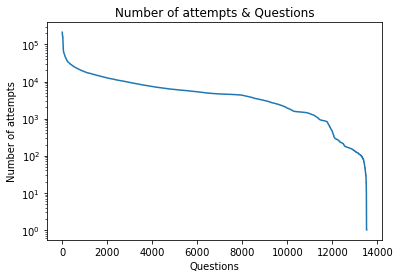

In [22]:
plt.plot(content_df['user_id'].sort_values(ascending=False).values)
plt.yscale("log")
plt.title("Number of attempts & Questions")
plt.xlabel("Questions")
plt.ylabel("Number of attempts")
plt.show()

### Are the difficulty of the questions varying?

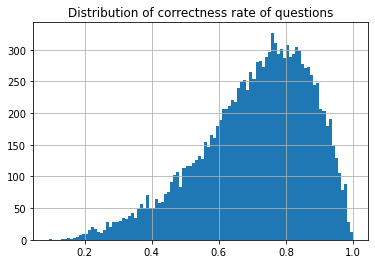

In [23]:
content_df[content_df['user_id']>100]['answered_correctly'].hist(bins=100)
plt.title("Distribution of correctness rate of questions")
plt.show()

### Distribution of time use on previous questions


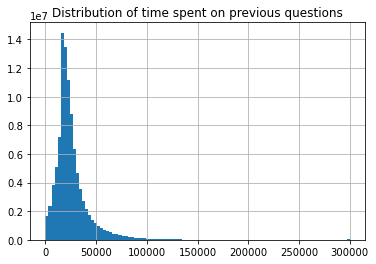

In [24]:
df['prior_question_elapsed_time'].compute().hist(bins=100)
plt.title("Distribution of time spent on previous questions")
plt.show()

### Is time elapsed on previous question related to correctness?

In [25]:
prior_question_qcut = df['prior_question_elapsed_time'].map_partitions(pd.qcut, 10, labels=False,\
meta=df['prior_question_elapsed_time'])

In [26]:
pq_df = (df.groupby(prior_question_qcut).agg({'answered_correctly': 'mean'}).compute()
           .reset_index().rename(columns={'prior_question_elapsed_time': 'prior_question_elapsed_time_decile'}))

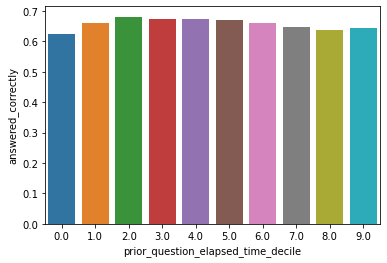

In [27]:
sns.barplot(x='prior_question_elapsed_time_decile', y='answered_correctly', data=pq_df)
plt.show()

### Does explanation for prior question correlate to predict the correctness ?

In [28]:
df.groupby('prior_question_had_explanation').agg({'user_id': 'count', 'answered_correctly': 'mean'}).compute()

,user_id,answered_correctly
prior_question_had_explanation,,
False,11152266,0.237025
True,89685560,0.673189


### Does the section of the test (variable part) correlate to predict answer correctness?


In [29]:
part_agg = content_df.groupby('part', as_index=False).agg({'user_id': 'sum', 'num_answered_correctly': 'sum'})
part_agg['prop_correct'] = part_agg['num_answered_correctly'] / part_agg['user_id']
part_agg

,part,user_id,num_answered_correctly,prop_correct
0,1,7454570,5553880,0.745030
1,2,18743404,13283284,0.708691
2,3,8639907,6060471,0.701451
3,4,8067676,5090641,0.630992
4,5,40908153,24957361,0.610083
5,6,10501472,7029513,0.669384
6,7,4956118,3269027,0.659594


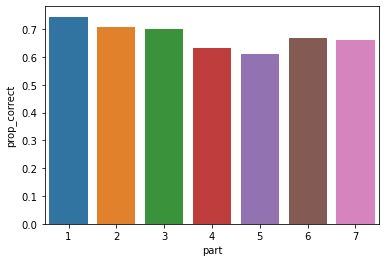

In [30]:
sns.barplot(x='part', y='prop_correct', data=part_agg, hue=None)
plt.show()

### Explore the tags

In [31]:
#clean the tags, convert the string to list
content_df['tags'].fillna('', inplace=True)
content_df['tags_list'] = content_df['tags'].apply(lambda x: [int(t) for t in x.split()])

In [32]:
from itertools import chain

tags_df = content_df.apply(lambda x: [(t, x['user_id'], x['num_answered_correctly']) for t in x['tags_list']],axis=1).values
tags_df = chain.from_iterable(tags_df)
tags_df = pd.DataFrame(tags_df, columns=['tag', 'num_questions', 'num_answered_correctly'])
tags_df = tags_df.groupby('tag', as_index=False).sum()
tags_df['prop_correct'] = tags_df['num_answered_correctly'] / tags_df['num_questions']
tags_df

,tag,num_questions,num_answered_correctly,prop_correct
0,0,326679,204655,0.626471
1,1,2409509,1465604,0.608258
2,2,1727202,1206066,0.698277
3,3,290278,187107,0.644579
4,4,499255,320362,0.641680
...,...,...,...,...
183,183,190269,130334,0.684999
184,184,288058,201479,0.699439
185,185,192498,139308,0.723685
186,186,9002,5055,0.561542


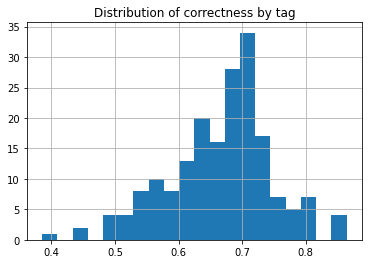

In [33]:
tags_df['prop_correct'].hist(bins=20)
plt.title("Distribution of correctness by tag")
plt.show()

### Analysis about the user

In [34]:
user_df = (df.query("content_type_id==0")
           .groupby('user_id')
           .agg({'user_answer': 'count', 'answered_correctly': 'mean', 'timestamp': 'max'})
           .rename(columns={'user_answer': 'num_questions_answered', 'timestamp': 'total_time_spent'})).compute()
user_df['total_time_spent_mins'] = user_df['total_time_spent'] / 60000.0
user_df.head()


,num_questions_answered,answered_correctly,total_time_spent,total_time_spent_mins
user_id,,,,
115,46,0.695652,668090043,11134.834050
124,30,0.233333,571323,9.522050
2746,19,0.578947,835457,13.924283
5382,125,0.672000,2101551456,35025.857600
8623,109,0.642202,862338736,14372.312267


### Distribution of number of questions answered by each user

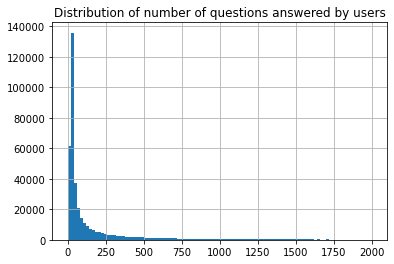

In [35]:
user_df[user_df['num_questions_answered'] < 2000]['num_questions_answered'].hist(bins=100)
plt.title("Distribution of number of questions answered by users")
plt.show()

### Distribution of total time spent


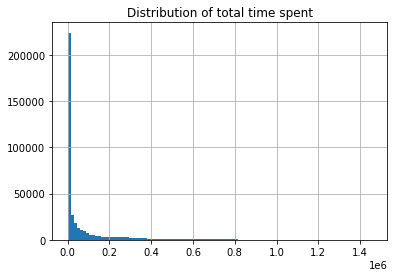

In [36]:
user_df['total_time_spent_mins'].hist(bins=100)
plt.title("Distribution of total time spent")
plt.show()

### Potential Outliers : users with millions of minutes


In [37]:
outlier_user_ids = df[df['timestamp'] > 1e6 * 60000][['user_id']].drop_duplicates()
outlier_user_df = outlier_user_ids.merge(df, how='inner', on='user_id').compute()

In [38]:
outlier_user_df

,user_id,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,2726001,136260,0,7900,0,0,1,0,NaN,NaN
1,2726001,136261,23598,7876,0,1,0,0,27000.0,False
2,2726001,136262,50822,175,0,2,1,0,21000.0,False
3,2726001,136263,70505,1278,0,3,3,1,25000.0,False
4,2726001,136264,150225,2065,0,4,0,0,17000.0,False
...,...,...,...,...,...,...,...,...,...,...
9246,2147192453,101221106,60402896564,832,0,888,3,1,12000.0,True
9247,2147192453,101221107,60402924679,564,0,889,0,1,16000.0,True
9248,2147192453,101221108,60402951816,1068,0,890,0,1,18000.0,True
9249,2147192453,101221109,60402980491,1083,0,891,1,1,18000.0,True


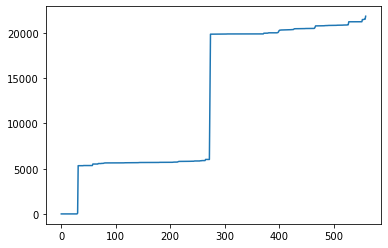

In [39]:
import numpy as np

sample_user = outlier_user_df[outlier_user_df['user_id']==np.random.choice(outlier_user_df['user_id'].unique())].copy()
sample_user['timestamp_mins'] = sample_user['timestamp'] / 60000
sample_user['timestamp_hrs'] = sample_user['timestamp_mins'] / 60
plt.plot(sample_user['timestamp_hrs'].values)
plt.show()

In [40]:
sample_user.head(50)


,user_id,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,timestamp_mins,timestamp_hrs
20613,1922901440,90579423,0,128,0,0,0,1,NaN,NaN,0.000000,0.000000
20614,1922901440,90579424,25112,7860,0,1,0,1,53000.0,False,0.418533,0.006976
20615,1922901440,90579425,44017,7922,0,2,1,1,22000.0,False,0.733617,0.012227
20616,1922901440,90579426,65506,156,0,3,2,1,16000.0,False,1.091767,0.018196
20617,1922901440,90579427,87518,51,0,4,0,1,17000.0,False,1.458633,0.024311
20618,1922901440,90579428,111211,50,0,5,3,1,19000.0,False,1.853517,0.030892
20619,1922901440,90579429,130695,7896,0,6,2,1,21000.0,False,2.178250,0.036304
20620,1922901440,90579430,152339,7863,0,7,0,1,17000.0,False,2.538983,0.042316
20621,1922901440,90579431,175366,152,0,8,1,1,19000.0,False,2.922767,0.048713
20622,1922901440,90579432,201885,104,0,9,2,1,20000.0,False,3.364750,0.056079


### Distribution of user ablility, some people always have higher correct rate?

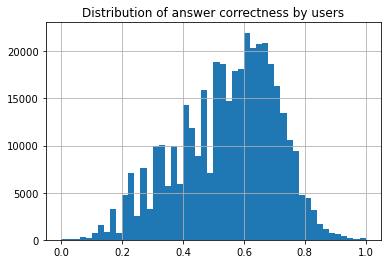

In [41]:
user_df[user_df['num_questions_answered']>10]['answered_correctly'].hist(bins=50)
plt.title("Distribution of answer correctness by users")
plt.show()

### Distribution of lectures

In [42]:
lectures_df = pd.read_csv('lectures.csv')
lectures_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [43]:
lectures_df.head()


,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
